# Tutorial Brief

Web scrpping a one of the most common method of collecting data. This tutorial covers the basics of web scraping.

**Video Tutorial**:

http://youtu.be/wT66i7jeyL8

More About LXML:

http://lxml.de/

In [1]:
from datetime import datetime

from lxml import html
import requests

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

pd.options.display.max_columns=50

# Data and Data Source

We will be working with the Nobel Prize data. We will get that from Wikipedia
![](http://upload.wikimedia.org/wikipedia/en/e/ed/Nobel_Prize.png)

Webpage URL:

http://en.wikipedia.org/wiki/List_of_Nobel_laureates

## Before you Web Scrape - Read the ToS

Please make sure that you read the ToS (Terms of Service) of the website before you web scrape any data. Most websites don't allows web scraping of their content. Some allow moderate use.

For Wikipedia:

> ## 4. Refraining from Certain Activities
> ### Engaging in Disruptive and Illegal Misuse of Facilities
>  Engaging in automated uses of the site that are abusive or disruptive of the services and have not been approved by the Wikimedia community;
> ##### [Wikimedia Foundation Terms of Use](wikimediafoundation.org/wiki/Terms_of_Use#4._Refraining_from_Certain_Activities)

**From my basic technical understanding**:

This means "automated uses" like web scraping are not allowed if they are "abusive or disruptive of the services" but I would argue web scraping a single page is not "abusive or disruptive of the services". Web scraping will actually consume less servers time and bandwidth than reading the page in a browser. This is due to the fact that we will only request the page and none of the static files linked to it like CSS, images, javascript ... etc.

**DISCLAIMERL**: I'm not a lawyer

##Basic Rules:

- Check if there is an API use it. It will make your life easier.
- Don't use scrape too much in a short time. It slows down the servers and might gets you banned from the website.
- Never scrape anything that is not public.
- Check /robots.txt for allowed paths

# Fetch page & build HTML tree

In [2]:
def print_element(element):
    print "<%s %s>%s ..." % (element.tag, element.attrib, element.text_content()[:200].replace("\n", " "))

In [3]:
page = requests.get('http://en.wikipedia.org/wiki/List_of_Nobel_laureates')
tree = html.fromstring(page.text)
print_element(tree)

<html {'lang': 'en', 'class': 'client-nojs', 'dir': 'ltr'}>   List of Nobel laureates - Wikipedia, the free encyclopedia              a:lang(ar),a:lang(kk-arab),a:lang(mzn),a:lang(ps),a:lang(ur){text-decoration:none} /* cache key: enwiki:resourceloader:filter ...


## Locate The table

### First we find all tables

In [4]:
tables = tree.xpath('//table')
for table in tables:
    print_element(table)

<table {'class': 'wikitable sortable'}>  Year Physics Chemistry Physiology or Medicine Literature Peace Economics   1901 Röntgen, WilhelmWilhelm Röntgen Hoff, Jacobus Henricus van 'tJacobus Henricus van 't Hoff von Behring, Emil AdolfEmil  ...
<table {'style': 'border:1px solid #aaa;background-color:#f9f9f9', 'class': 'mbox-small plainlinks'}>   Wikimedia Commons has media related to Nobel laureates.   ...
<table {'style': 'border-spacing:0;', 'cellspacing': '0', 'class': 'navbox'}>        v t e   Nobel Prizes       Prizes    Chemistry Economics1 Literature Peace Physics Physiology or Medicine         Laureates     by subject    Chemistry Economics Literature Peace Physics Physi ...
<table {'style': 'border-spacing:0;background:transparent;color:inherit;', 'cellspacing': '0', 'class': 'nowraplinks hlist collapsible collapsed navbox-inner'}>     v t e   Nobel Prizes       Prizes    Chemistry Economics1 Literature Peace Physics Physiology or Medicine         Laureates     by subject    C

**When locating the table watchout for client side javascript alteration to the HTML code**

In [5]:
table = tree.xpath('//table[@class="wikitable sortable"]')[0]
print_element(table)

<table {'class': 'wikitable sortable'}>  Year Physics Chemistry Physiology or Medicine Literature Peace Economics   1901 Röntgen, WilhelmWilhelm Röntgen Hoff, Jacobus Henricus van 'tJacobus Henricus van 't Hoff von Behring, Emil AdolfEmil  ...


## Extract the Subjects & Years

In [6]:
subjects = [subject[0].text_content().replace("\n"," ") for subject in table.xpath('tr')[0][1:]]
subjects

['Physics',
 'Chemistry',
 'Physiology or Medicine',
 'Literature',
 'Peace',
 'Economics']

In [7]:
years = [item[0].text for item in table.xpath('tr')[1:-1]]

## Extract Winners Data

### Testing for a sigle years

In [8]:
for index, item in enumerate(table.xpath('tr')[1][1:]):
    subject = subjects[index]
    print "%s:" % subject
    for winner in item.xpath('span[@class="vcard"]/span/a'):
        winner_name = winner.attrib["title"]
        winner_url = winner.attrib["href"]
        print " - %s" % winner_name


Physics:
 - Wilhelm Röntgen
Chemistry:
 - Jacobus Henricus van 't Hoff
Physiology or Medicine:
 - Emil Adolf von Behring
Literature:
 - Sully Prudhomme
Peace:
 - Henry Dunant
 - Frédéric Passy
Economics:


### Extract The complete table

In [9]:
year_list = []
subject_list = []
name_list = []
url_list = []
for y_index, year in enumerate(years):
    #print year
    for index, item in enumerate(table.xpath('tr')[y_index + 1][1:]):
        subject = subjects[index]
        #print "%s:" % subject
        for winner in item.xpath('span[@class="vcard"]/span/a'):
            winner_name = winner.attrib["title"]
            winner_url = winner.attrib["href"]
            #print " - %s" % winner_name
            year_list.append(year)
            subject_list.append(subject)
            name_list.append(winner_name)
            url_list.append(winner_url)

# Post Processing in Pandas

In [10]:
data_set = pd.DataFrame(name_list, columns=["winner_name"])
data_set["subject"] = subject_list
data_set["year"] = year_list
data_set["year"] = data_set["year"].astype(np.int32)
data_set["url"] = url_list
data_set.head(5)

winner_name                 subject  year                                   url
0               Wilhelm Röntgen                 Physics  1901            /wiki/Wilhelm_R%C3%B6ntgen
1  Jacobus Henricus van 't Hoff               Chemistry  1901  /wiki/Jacobus_Henricus_van_%27t_Hoff
2        Emil Adolf von Behring  Physiology or Medicine  1901          /wiki/Emil_Adolf_von_Behring
3               Sully Prudhomme              Literature  1901                 /wiki/Sully_Prudhomme
4                  Henry Dunant                   Peace  1901                    /wiki/Henry_Dunant

## Looking at the data

In [11]:
years_df = data_set["year"].value_counts().sort_index()
years_df

1901    6
1902    7
1903    7
1904    5
1905    5
1906    6
1907    6
1908    7
1909    7
1910    4
1911    6
1912    6
1913    5
1914    3
1915    4
...
1999     6
2000    13
2001    14
2002    13
2003    11
2004    12
2005    12
2006     8
2007    11
2008    12
2009    13
2010    11
2011    13
2012    10
2013    13
Length: 110, dtype: int64

## Number of Prizes per Year

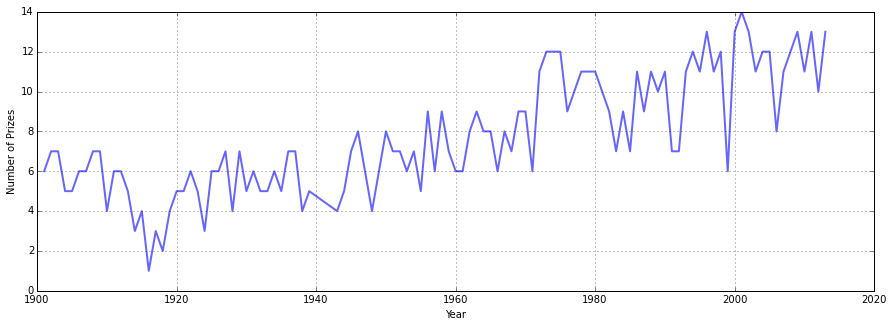

Total Prizes: 853


In [12]:
plt.figure(figsize=(15,5))
plt.plot(years_df.index, years_df.values, linewidth=2, alpha=.6)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Number of Prizes")
plt.show();
print "Total Prizes: %s" % len(data_set)

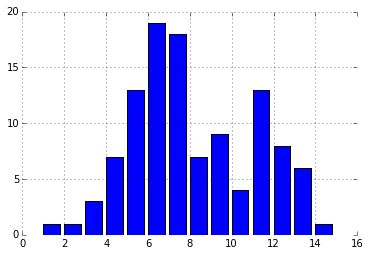

In [13]:
years_df.value_counts()
plt.bar(years_df.value_counts().index, years_df.value_counts())
plt.box(on="off")
plt.grid()
plt.xlabel("Number of Nober Prizes/Year")
plt.xlabel("")
plt.show();

## By Subject

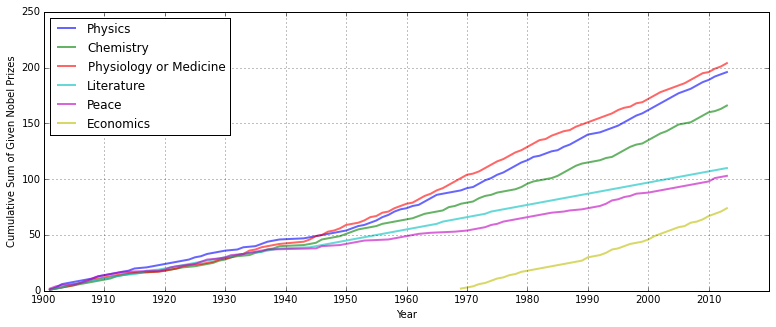

In [14]:
plt.figure(figsize=(13,5))

for subject in subjects:
    df = data_set[data_set["subject"]==subject]["year"].value_counts().sort_index().cumsum()
    plt.plot(df.index, df, label=subject, linewidth=2, alpha=.6)


plt.grid()
plt.legend(loc="best")
plt.xlabel("Year")
plt.ylabel("Cumulative Sum of Given Nobel Prizes")
plt.xticks(np.arange(1900, 2020, 10))

plt.show();

# The effects of WW I and WW II

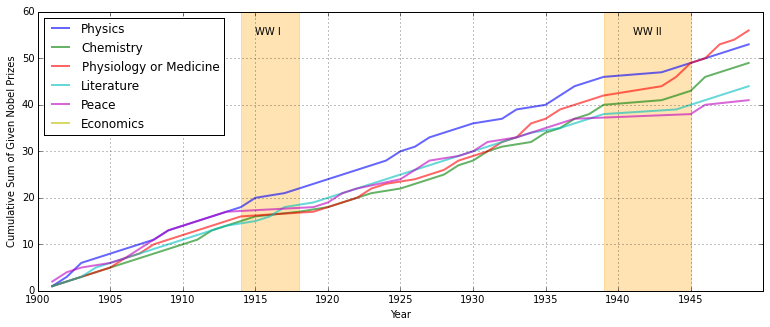

In [15]:
plt.figure(figsize=(13,5))

for subject in subjects:
    df = data_set[(data_set["subject"]==subject) &
                  (data_set["year"].astype(np.int32)<1950)]["year"].value_counts().sort_index().cumsum()
    plt.plot(df.index, df, label=subject, linewidth=2, alpha=.6)

plt.grid()
plt.legend(loc="best")
plt.xlabel("Year")
plt.ylabel("Cumulative Sum of Given Nobel Prizes")
plt.xticks(np.arange(1900, 1950, 5))

gca = plt.gca()

gca.add_patch(plt.Rectangle((1914,0), 4, 60, alpha=.3, color="orange"))
gca.add_patch(plt.Rectangle((1939,0), (45-39), 60, alpha=.3, color="orange"))

plt.annotate(s="WW I", xy=(1915,55))
plt.annotate(s="WW II", xy=(1941,55))
plt.show();